# <font color="brown"> Analysis for High-resolution Spectral Data</font>
_<font color="grey">Last updated: 060617</font>_

## <font color="red"> Information about M82</font>
Extracted from our proposal

<img src='https://github.com/Mipanox/PHYS301/blob/master/Project/imgs/M82.png?raw=true' width=90%> </img>

## <font color="blue"> Preparations</font>

In [23]:
%%capture
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/afs/ir.stanford.edu/class/physics100/workdir/g2/Jason/codes/")

import pyfits
import numpy as np
import matplotlib.pyplot as plt
from util import *
from matplotlib.colors import LogNorm
import astropy.units as u
% matplotlib inline

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18

_Use the best observations obtained on 060117_

In [2]:
predir  = '/afs/ir.stanford.edu/class/physics100/workdir/g2/final/spectra/'
workdir = '/afs/ir.stanford.edu/class/physics100/workdir/g2/Jason/Project/'
datdir  = predir+'spec_0601/'

### 1. Plate Scale
From the justification [notebook](https://nbviewer.jupyter.org/github/Mipanox/PHYS301/blob/master/Project/SpecAss.ipynb), we know the plate scale:

In [3]:
plate_scale = np.load(workdir+'others/plate_scale.npy') * u.arcsec

### 2. ROI
Define our apertures

In [4]:
M82_data = pyfits.open(datdir+'m82_60min.fit')[0].data
M82_hdr  = pyfits.open(datdir+'m82_60min.fit')[0].header

(200, 260)

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


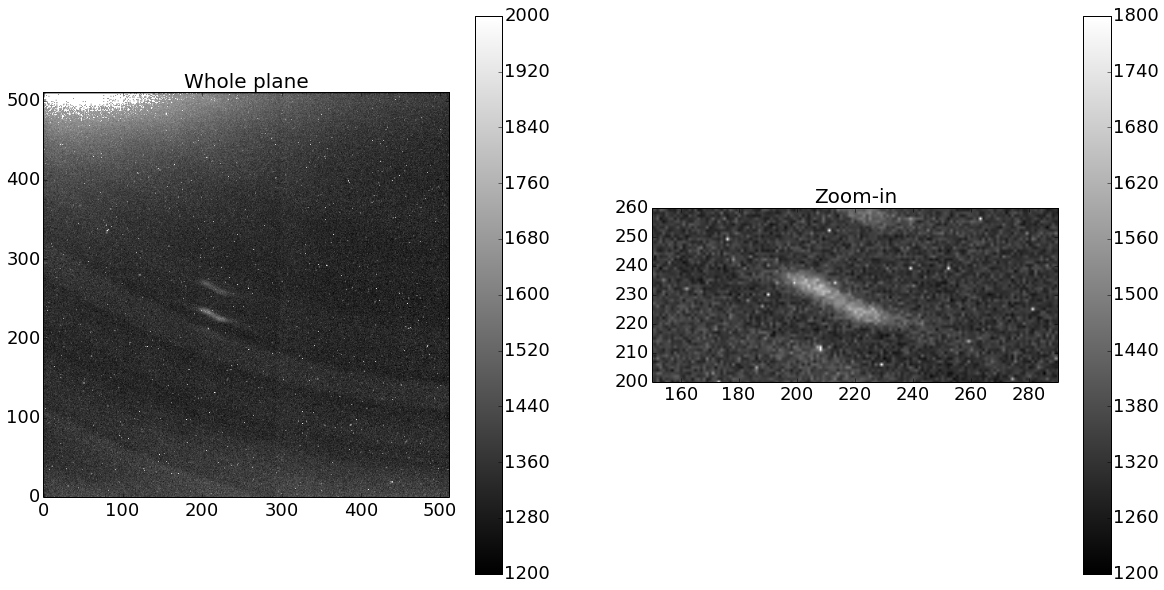

In [5]:
roi_x = np.array((150,290))
roi_y = np.array((200,260))
np.save(workdir+'others/roi_x.npy',roi_x)
np.save(workdir+'others/roi_y.npy',roi_y)

M82_data[M82_data>1700] = np.nan

plt.figure(figsize=(20,10))
plt.subplot(121); plt.title('Whole plane')
plt.imshow(M82_data,origin='lower',cmap='gray'); plt.colorbar(); plt.clim(1200,2000)
plt.subplot(122); plt.title('Zoom-in')
plt.imshow(M82_data,origin='lower',cmap='gray'); plt.colorbar(); plt.clim(1200,1800)
plt.xlim(roi_x); plt.ylim(roi_y)

We shall we super optimistic and take this 140 pixels across, which correspond to 

In [6]:
print 'Optimistic diameter = {0:.3f}'.format(140*plate_scale)

Optimistic diameter = 111.138 arcsec


#### Spectrum in each column (in the ROI)

In [7]:
M82_data_roi = np.copy(M82_data[roi_y[0]:roi_y[1],roi_x[0]:roi_x[1]])

M82_spec = []
for i in range(M82_data_roi.shape[1]):
    M82_spec.append(M82_data_roi[:,i])

Example cut along column #200 (in the zoom-in image above)

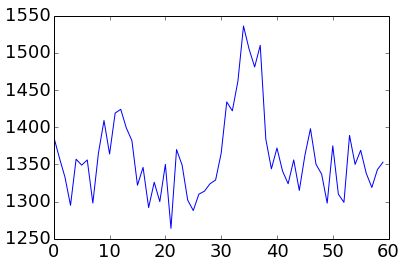

In [12]:
plt.plot(M82_spec[50])

### Component Identification
_Only do the brightest H-$\alpha$_

#### Prominent feature detection by convolving a proper-sized Gaussian
The width of the Gaussian is chosen according to the observed width of the spectrum as exemplied above: ~7 pixels. See also the Supplementary Stuff below for example resulting spectra

In [25]:
M82_spec_conv = conv_gaus(M82_spec,7.)

#### Pick out true peak in the relevant wavelength range.
Since physically we expect the gas to have a l.o.s. velocity around a few km/s, which is only a tiny deviation from the rest frequency (~5 A), we can neglect everything outside this near-zone (around +/- 10 pixels across row) -- which eliminates the fake peaks of noises

_The ranges of rows at each spatial location are justified from the arc spectrum_

In [43]:
Halp_peak_idx = []
for i in range(len(M82_spec)):
    if i < 20:
        Halp_peak_idx.append(np.argmax(M82_spec_conv[i][-20:])+len(M82_spec_conv[i])-20)
    elif i < 30:
        Halp_peak_idx.append(np.argmax(M82_spec_conv[i][-22:])+len(M82_spec_conv[i])-22)
    elif i < 40:
        Halp_peak_idx.append(np.argmax(M82_spec_conv[i][-25:])+len(M82_spec_conv[i])-25)
    elif i < 80:
        Halp_peak_idx.append(np.argmax(M82_spec_conv[i]))
    elif i < 100:
        Halp_peak_idx.append(np.argmax(M82_spec_conv[i][:25]))
    elif i < 110:
        Halp_peak_idx.append(np.argmax(M82_spec_conv[i][:20]))
    else:
        Halp_peak_idx.append(np.argmax(M82_spec_conv[i][:15]))

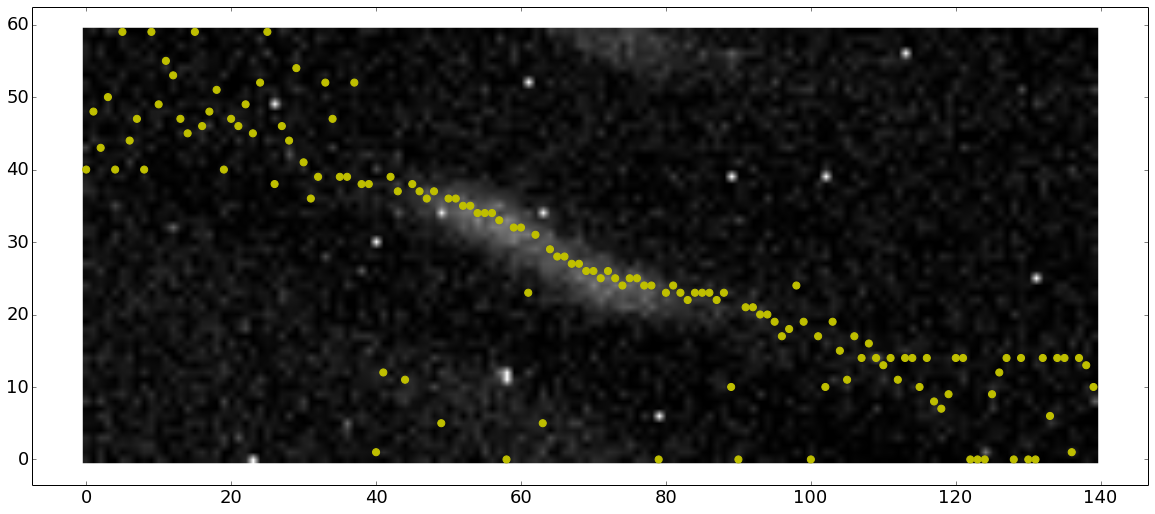

In [44]:
plt.figure(figsize=(20,13))
plt.imshow(M82_data_roi,origin='lower',cmap='gray'); plt.clim(1300,2000)

for i in range(len(M82_Halp_idx)):
    plt.scatter(i,Halp_peak_idx[i],color='y',s=50)

Certainly, the data still suffers from noises when it's too far away from the central region. Perhaps a good choise for boundary will be columns #20 to #120, and get rid of the "mistaken" peaks

## <font color="blue"> Extracting Spectra</font>

### 1. Wavelength Calibration
_Use the arclamp standard spectrum_<br>
_(Ref: http://www.astrosurf.com/buil/us/spe2/calib2/neon1.gif)_
<img src='http://www.astrosurf.com/buil/us/spe2/calib2/neon1.gif' width=80%> </img>

#### Arc in ROIz
_**Note**: ROIz is the zoomed-out (in y) version defined in [here](https://nbviewer.jupyter.org/github/Mipanox/PHYS301/blob/master/Project/SpecAss.ipynb#Uniform-along-the-slit-in-the-ROI-(~linear))_

In [50]:
arc_data = pyfits.open(datdir+'Arc.fit')[0].data
arc_hdr  = pyfits.open(datdir+'Arc.fit')[0].header

In [52]:
arc_roi = np.copy(arc_data[roi_y[0]:roi_y[1],roi_x[0]:roi_x[1]])

arc_spec = []
for i in range(arc_roi.shape[1]):
    arc_spec.append(arc_roi[:,i])

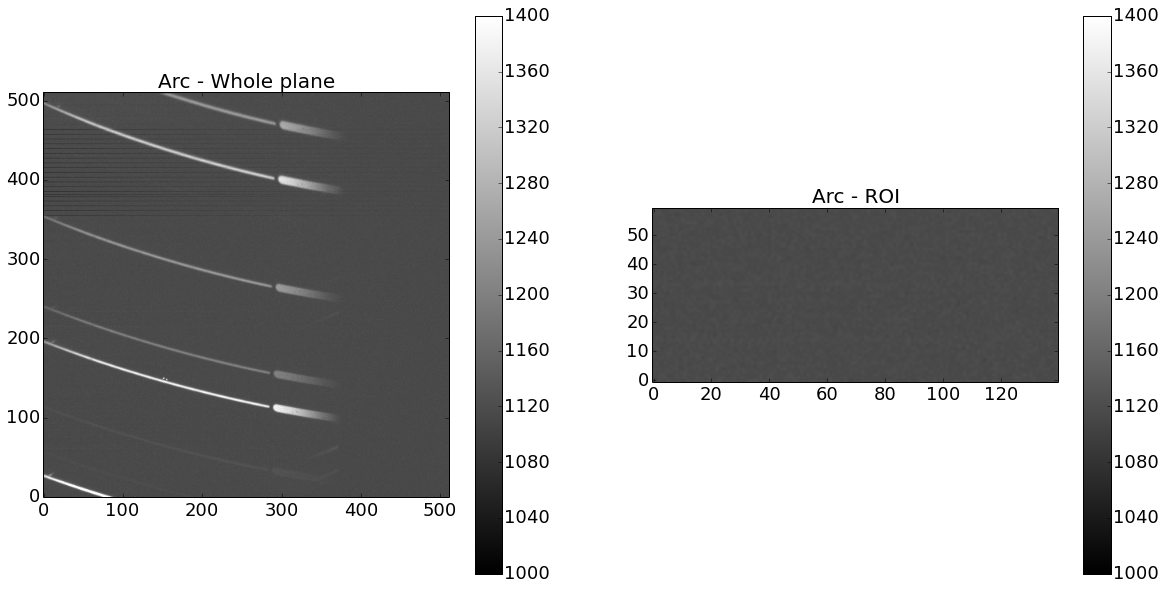

In [54]:
plt.figure(figsize=(20,10))
plt.subplot(121); plt.title('Arc - Whole plane')
plt.imshow(arc_data,origin='lower',cmap='gray'); plt.colorbar(); plt.clim(1000,1400)
plt.subplot(122); plt.title('Arc - ROI')
plt.imshow(arc_roi,origin='lower',cmap='gray'); plt.colorbar(); plt.clim(1000,1400)

#### ROI

## <font color="blue"> Analysis - Rotation Curve</font>

# <font color="magenta">Procedure:</font>
1. ROI
2. convolve gaussian along spectral direction
3. choose peaks around "central frequency"
4. bin spatially ~ 6 pixs according to shifting...
5. claim error bars: (1) spatial: bin size (2) dominant convolution width

---
## <font color="brown">Supplementary Stuff</font>
1. Earlier attemps that are obsolete
2. Showcase some intermediate steps in analysis

### Idetifying emission via max/second largest position

In [11]:
M82_Halp_idx = []
M82_Halp_val = []
for i in range(len(M82_spec)):
    M82_Halp_idx.append(np.argmax(M82_spec[i]))
    M82_Halp_val.append(np.max(M82_spec[i]))
    
M82_Halp_2idx = []
for i in range(len(M82_spec)):
    M82_Halp_2idx.append(second_largest(M82_spec[i])[1])

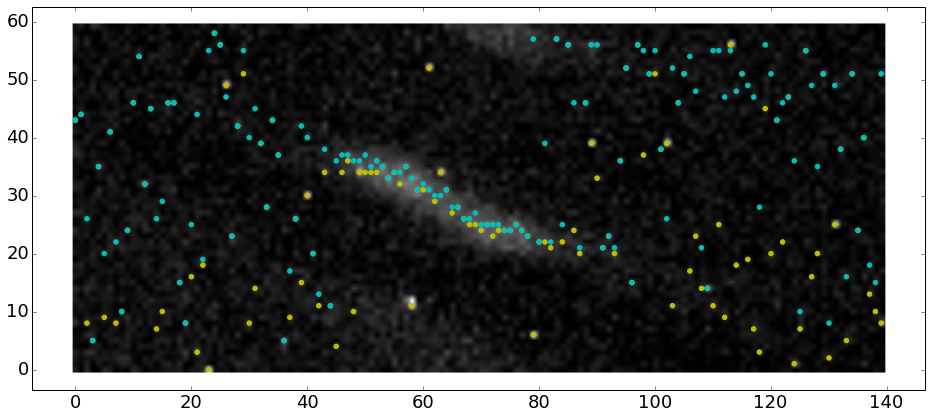

In [14]:
plt.figure(figsize=(16,8))
plt.imshow(M82_data_roi,origin='lower',cmap='gray'); plt.clim(1300,2000)

for i in range(len(M82_Halp_idx)):
    plt.scatter(i,M82_Halp_idx[i],color='y')
    plt.scatter(i,M82_Halp_2idx[i],color='c')

Clearly this method cannot give us satisfactory identification, when the SN is too low

### Convolution with Gaussian: Feature detection
Here shows some spectra after convolution. Note that some "noises" are also picked up but the correct peak is the only one in the relevant wavelength range

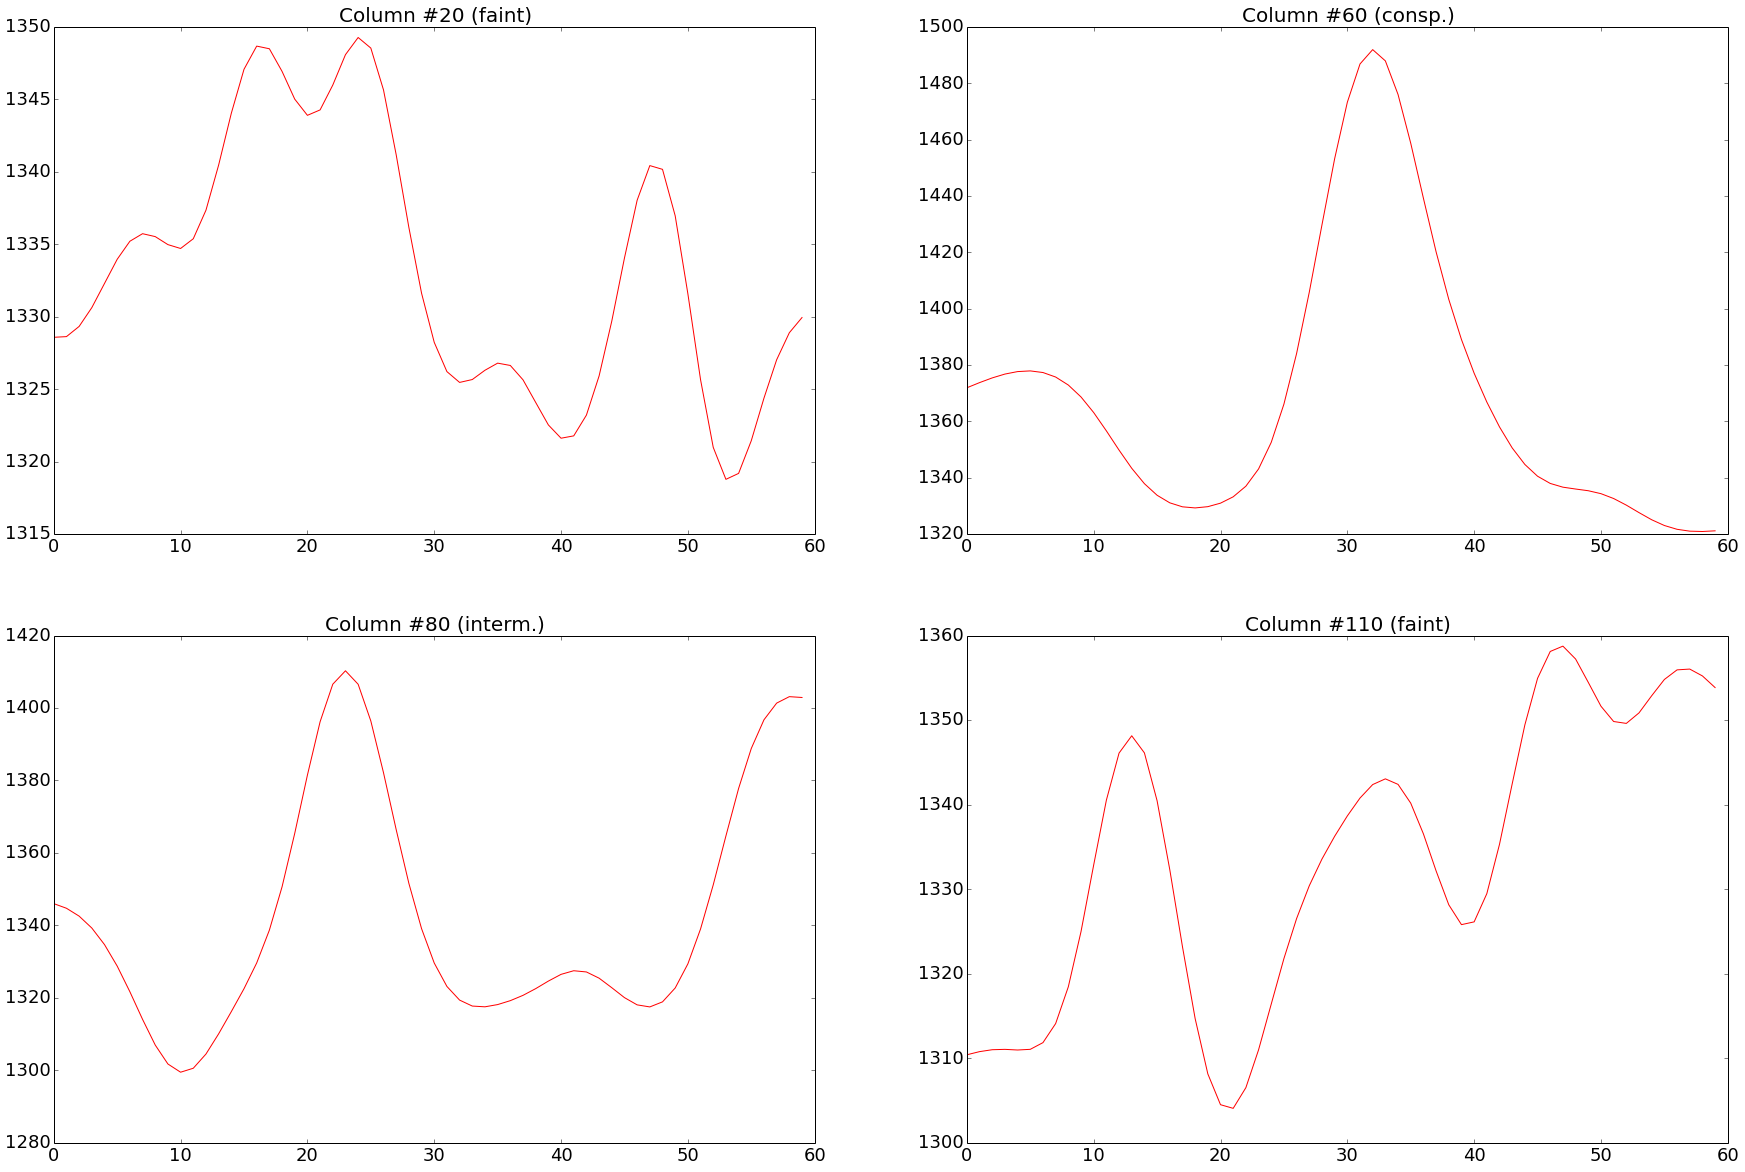

In [48]:
plt.figure(figsize=(30,20))
plt.subplot(221); plt.plot(M82_spec_conv[20],'r'); plt.title('Column #20 (faint)')
plt.subplot(222); plt.plot(M82_spec_conv[60],'r'); plt.title('Column #60 (consp.)')
plt.subplot(223); plt.plot(M82_spec_conv[80],'r'); plt.title('Column #80 (interm.)')
plt.subplot(224); plt.plot(M82_spec_conv[110],'r'); plt.title('Column #110 (faint)')

Starting from top left, the "true" peak is around x=50,30,20,10 respectively